In [1]:
from renewableopt.battery.data_import import DATA_DIR
from renewableopt.battery.feature_extraction import CapacityData
from renewableopt.battery.gaussian_process import preprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [2]:
def groupby(X, label):
    keys, indices = np.unique(X[label], return_inverse=True)
    return [X[np.where(indices == k)] for k in range(len(keys))]



In [3]:
def matching_u(groups):
    groups = groups.copy()
    out = {}

    while groups:
        g = groups.pop(0)
        uid = g['uid'][0]
        uid_start = uid[:7]
        stage = uid[-1]
        
        exp_id = uid_start + stage
        out[exp_id] = [g]
        to_remove = []
        for i, h in enumerate(groups):
            h_uid = h['uid'][0]
            if h_uid.startswith(uid_start) and h_uid.endswith(stage):
                out[exp_id].append(h)
                to_remove.append(i)
        groups = [h for i, h in enumerate(groups) if i not in to_remove]
    return out    
    

In [4]:
def filter_by_exp_temp(X):
    T_m = np.unique(X0['T_m'])
    counts = [np.sum(X0['T_m'] == T) for T in T_m]
    T_selected = T_m[np.argmax(counts)]
    return X[X['T_m'] == T_selected]
    
    

In [5]:
def average_cap(x):
    return (x['c_ch'] + x['c_dch']) / 2

In [6]:
def load_X():
    c = CapacityData.load(DATA_DIR / "aging.npz")
    exp = pd.read_csv(DATA_DIR / "experiments_meta.csv")
    return preprocess(c, exp)
    
def load_by_experiment():
    X = load_X()    
    g = groupby(X, 'uid')
    
    return matching_u(g)

In [9]:

by_exp = load_by_experiment()

In [10]:
X = load_X()

## Gaussian Process Regressor

In [27]:
def fit_simple_gp(X):
    # Define the kernel and GP model
    kernel = WhiteKernel(0.1, (1e-4, 1e3)) + RBF(10, (1e-3, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel,
                                  # optimizer=None,
                                  n_restarts_optimizer=10,
                                  normalize_y=True,
                                  alpha=0.005)
    
    # Train the model
    gp.fit(X['k'].reshape(-1, 1), average_cap(X))
    print("original params:", np.exp(gp.kernel.theta))
    print("optimized:", np.exp(gp.kernel_.theta))
    return gp

In [38]:
X.dtype

dtype([('uid', '<U11'), ('T', '<f8'), ('T_m', '<f8'), ('delta', '<f8'), ('Q', '<f8'), ('gamma_ch', '<f8'), ('gamma_dch', '<f8'), ('k', '<f8'), ('c_ch', '<f8'), ('c_dch', '<f8')])

In [104]:
l = [(1, 2), (3, 4), (5, 6)]

In [107]:
list(zip(*l))

[(1, 3, 5), (2, 4, 6)]

In [135]:
X.dtype

dtype([('uid', '<U11'), ('T', '<f8'), ('T_m', '<f8'), ('delta', '<f8'), ('Q', '<f8'), ('gamma_ch', '<f8'), ('gamma_dch', '<f8'), ('k', '<f8'), ('c_ch', '<f8'), ('c_dch', '<f8')])

In [136]:
X["gamma_ch"].shape

(1874,)

In [148]:
np.concatenate([X['gamma_ch'], X['gamma_ch']], axis=1).shape

AxisError: axis 1 is out of bounds for array of dimension 1

In [188]:
print(gp.kernel_)
print(np.exp(gp.kernel_.theta))

WhiteKernel(noise_level=0.1) + RBF(length_scale=[0.116, 13.5, 756])
[1.00000000e-01 1.16044418e-01 1.34761254e+01 7.55862929e+02]


In [62]:
def fit_full_gp(X):
    X = X[~np.isnan(X['k'])]
    c = average_cap(X) 

    keys, initial_guesses, bounds = zip(*[
        # ("Q"], 0.1),
        # ("delta"], 0.1),
        # ("gamma_dch"], 0.5),
        ("gamma_ch", 0.1, [1e-3, 0.2]),
        ("T", 10, [5, 25]),
        # ("T_m", 10,
        ("k", 1000, [500, 3000])
    ])
    
    features = np.concatenate([X[k].reshape(-1, 1) for k in keys], axis=1)
    print(features.shape)
    
        
        
    kernel = WhiteKernel(0.1, (1e-4, 0.1)) + RBF(initial_guesses, bounds)
    # kernel =  RBF(initial_guesses, (1e-3, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel,
                                  # optimizer=None,
                                  n_restarts_optimizer=1,
                                  normalize_y=True,
                                  alpha=0.005)

    gp.fit(features, c)
    gp.keys = keys
    return gp

In [120]:
np.nanmax

<function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [157]:
X_test = np.c_[X["gamma_ch"], X["T"], X["k"]]
print(X_test.shape)
to_keep = ~np.any(np.isnan(X_test), axis=1)
print(np.sum(to_keep))
X_test = X_test[to_remove]
print(X_test.shape)
y_all = gp.predict(X_test)

(1874, 3)
1858
(1858, 3)


In [159]:
sigma_c2 = 459 * 1e-6

In [171]:
y_all[:10]

array([4.77771844, 4.77771844, 4.77771844, 4.75664759, 4.73690332,
       4.7187924 , 4.6878628 , 4.66585124, 4.64999766, 4.62241387])

In [172]:
average_cap(X[to_keep][:10])

array([4.69507957, 4.76102972, 4.86043859, 4.75950885, 4.73447967,
       4.71610141, 4.68483043, 4.67018843, 4.6527648 , 4.61802649])

In [213]:
err_all = (y_all - average_cap(X[to_keep])) 
chi2 = np.sum(err_all**2) / sigma_c2

In [211]:
s = np.sqrt(sigma_c2)

In [214]:
chi2

20561.86298767632

In [183]:
from scipy.stats import norm

In [193]:
len(err_all)

1858

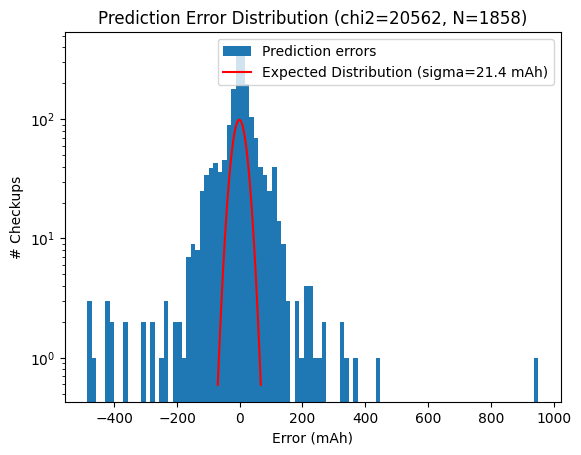

In [216]:
fig = plt.figure()
plt.title(f"Prediction Error Distribution (chi2={chi2:.0f}, N=1858)")
plt.hist(1e3 * err_all, log=True, bins=100, label="Prediction errors")
plt.xlabel("Error (mAh)")
plt.ylabel("# Checkups")

x = np.linspace(-70, 70)
# exp_count = len(dc) * norm.pdf(x, 0, 6.2)
exp_count = len(err_all) * np.diff(norm.cdf(x, loc=0, scale=1e3*np.sqrt(sigma_c2)))
plt.plot(x[:-1], exp_count, c='r', label="Expected Distribution (sigma=21.4 mAh)")
plt.legend()

In [217]:
fig.savefig(image_dir / "error_dist.png")

In [202]:
np.sum(exp_count)

1855.9827543844851

In [164]:
print(chi2)

20561.862987676315


In [165]:
len(y_all)

1858

In [142]:
def plot_cap_curve(grouped, gp=None):
    grouped_arr = np.c_[grouped]
    u = grouped[0][0]

    if gp is not None:
        # Compute predictions from GP
        n_points = 100
        # Assume that all groups are the same control params.
        row = grouped[0][0]
        print(row)
        X_test = np.concatenate([
            *[np.full((n_points, 1), row[k]) for k in gp.keys if k != 'k'],
            np.linspace(0, np.nanmax(grouped_arr['k']), 100).reshape(-1, 1)
        ], axis=1)
        mu, sigma = gp.predict(X_test, return_std=True)
        # mean_k = X_test.reshape(-1)
        mean_k = X_test[:, -1]

    else:
        # Compute mean and std over groups -- the old-fashioned way
        mean_k = np.mean(grouped_arr['k'], axis=0)
        c = average_cap(grouped_arr)
        mu = np.mean(c, axis=0)
        sigma = np.std(c, axis=0, ddof=1)
    
    fig = plt.figure()
    
    plt.plot(mean_k, mu)
    plt.fill_between(mean_k, mu-2*sigma, mu + 2*sigma, alpha=0.4)
    plt.xlabel("# Full Equivalent Cycles")
    plt.ylabel("Capacity (Ah)")
    plt.title(f"GPR result for conditions {u['uid']} (Δ={u['delta']}, γc={u['gamma_ch']}, γd={u['gamma_dch']}, T={u['T']}, Q={u['Q']})")
               
    
    for g in grouped:
        c = average_cap(g)
        plt.plot(g['k'], c, 'o')
    return fig

In [122]:
gp = fit_full_gp(X)

(1858, 3)


/home/sean/code/renewableopt/.hatch/jupyter/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [157]:
grouped[0][0]['Q']

0.7

experiment TP_z19_1
('TP_z19_01_1', 45., 45., 0.1, 0.3, 0.8, 0.9, 0., 4.99552774, 4.99260044)
Same number of checkups? True
('TP_z19_01_1', 45., 45., 0.1, 0.3, 0.8, 0.9, 0., 4.99552774, 4.99260044)


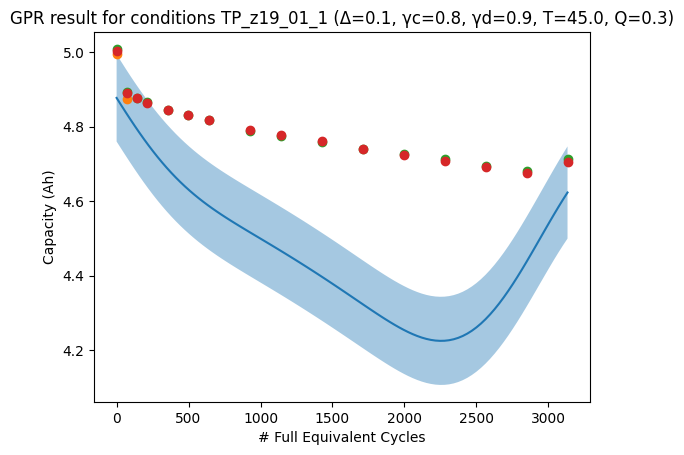

In [147]:
for i, (name, exp) in enumerate(by_exp.items()):
    # if name != "TP_z17_1":
        # Maximum variance
        # continue
    
    # if name != "TP_z11_2":
    #     # min variance
    #     continue
    if name != "TP_z19_1":
        # Mid variance
        continue
    # if name != "TP_z06_1":
    #     # Standard
    #     continue
    X0 = np.concatenate(exp)
    X0 = filter_by_exp_temp(X0)
    grouped = groupby(X0, 'uid')
    
    print(f"experiment {name}")
    print(X0[0])
    
    M = len(grouped)  # number of cells
    N = max([len(x) for x in grouped])  # number of checkups
    print(f"Same number of checkups? {np.all([len(x) == N for x in grouped])}")
    
    fig = plot_cap_curve(grouped, gp)
    # ans = input("exit? [y/n]")
    # if ans.startswith("y"):
    #     break
    # if i >= 1:
    #     break

In [78]:
from pathlib import Path

In [79]:
image_dir = Path("/home/sean/code/study-hard/stochastic-estimation/tex/project/draft/Images")


In [150]:
np.exp(gp.kernel.theta)

array([1.e-01, 1.e-01, 1.e+01, 1.e+03])

In [152]:
np.exp(gp.kernel_.theta)

array([1.00000000e-01, 1.16044418e-01, 1.34761254e+01, 7.55862929e+02])

In [148]:
fig.savefig(image_dir / "gp_spurious.png")

(array([351., 108.,  81.,  73.,  51.,  55.,  39.,  42.,  42.,  36.,  40.,
         30.,  23.,  32.,  31.,  41.,  24.,  26.,  54.,  20.,  21.,  28.,
         21.,  32.,  28.,  17.,  24.,  14.,  24.,  26.,  11.,  12.,  15.,
         21.,  15.,  43.,   3.,  21.,  21.,   6.,  25.,   2.,  10.,   6.,
          6.,   7.,  12.,   9.,   0.,   6.,  15.,   9.,  11.,   5.,   3.,
         12.,   9.,   3.,  16.,   0.,   0.,   2.,   7.,   3.,   6.,   3.,
          2.,   1.,   0.,   0.,   2.,   4.,   0.,   3.,   1.,   2.,   0.,
          0.,   0.,   5.,   1.,   0.,   0.,   2.,   1.,   0.,   3.,   9.,
          2.,   1.,   0.,   3.,   6.,   0.,   3.,   0.,   0.,   6.,   3.,
          9.]),
 array([   0.        ,   48.86772949,   97.73545898,  146.60318848,
         195.47091797,  244.33864746,  293.20637695,  342.07410645,
         390.94183594,  439.80956543,  488.67729492,  537.54502441,
         586.41275391,  635.2804834 ,  684.14821289,  733.01594238,
         781.88367188,  830.75140137,  879.619

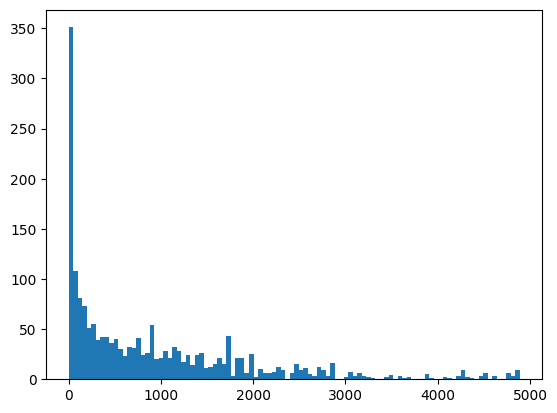

In [30]:
plt.hist(X["k"], bins=100)
# plt.ylim([0, 30])

In [58]:
print(np.std(c_diff))
print(np.std(c_diff[c_diff > -0.02]))

0.0047219126
0.0037938736


## 

# Covariance Matrix

In [58]:
names = []
covs = []
for name, group in by_exp.items():
    M = len(group)  # number of cells
    N = max([len(x) for x in group])  # number of checkups
    if not np.all([len(x) == N for x in group]):
        continue
    C = np.zeros((N, M), dtype=float)
    for i, g in enumerate(group):
        C[:, i] = average_cap(g)
    delta_C = C - np.mean(C, axis=1, keepdims=True)
    cov = 1 / (M-1) * delta_C @ delta_C.T
    covs.append(cov)
    names.append(name)
    
max_covs = [np.max(cov) for cov in covs]

In [98]:
np.argsort(max_covs)[-1]

22

In [112]:
names[np.argmin(max_covs)]

'TP_z11_2'

In [48]:
all_vars = np.concatenate([np.diag(cov) for cov in covs])

In [49]:
all_vars.shape

(592,)

In [50]:
covs[0].shape

(21, 21)

In [51]:
np.argmin(max_covs)

16

In [128]:
np.mean(all_vars)

0.00045701014293155737

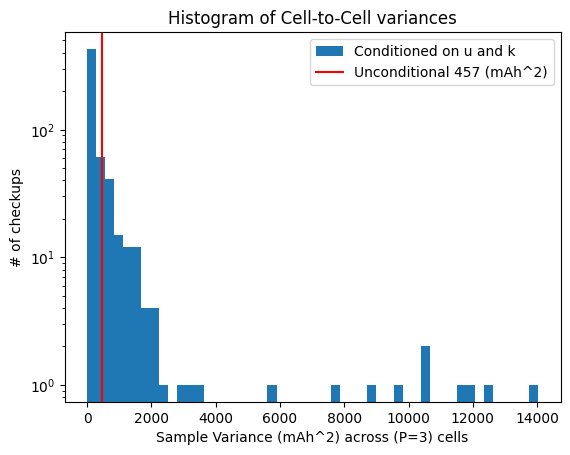

In [137]:
sigma_c = np.mean(all_vars) * 1e6
fig = plt.figure()
plt.hist(1e6 * all_vars, bins=50, log=True, label="Conditioned on u and k")
plt.axvline(x=sigma_c, c='r', label=f"Unconditional {sigma_c:.0f} (mAh^2)")
plt.title("Histogram of Cell-to-Cell variances")
plt.xlabel("Sample Variance (mAh^2) across (P=3) cells")
plt.ylabel("# of checkups")
plt.legend()

In [138]:
fig.savefig(image_dir / "cond_cell_to_cell_var.png")

<Figure size 640x480 with 0 Axes>

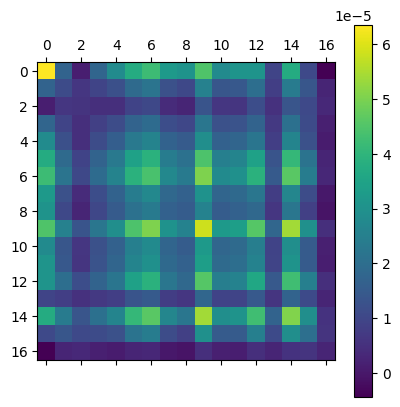

In [39]:
# Minimum
plt.figure()
plt.matshow(covs[np.argmin(max_covs)])
plt.colorbar()

TP_z19_1


<Figure size 640x480 with 0 Axes>

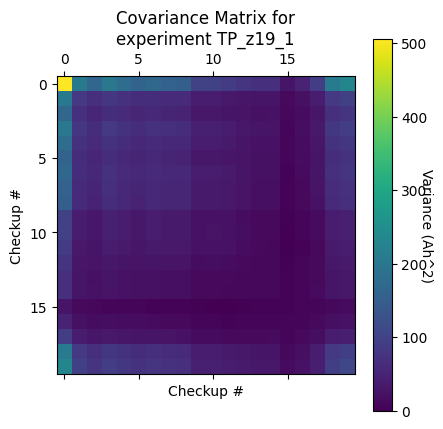

In [116]:
ind = np.argsort(max_covs)[13]
fig = cov_plot(covs[ind], names[ind])
print(names[ind])

<Figure size 640x480 with 0 Axes>

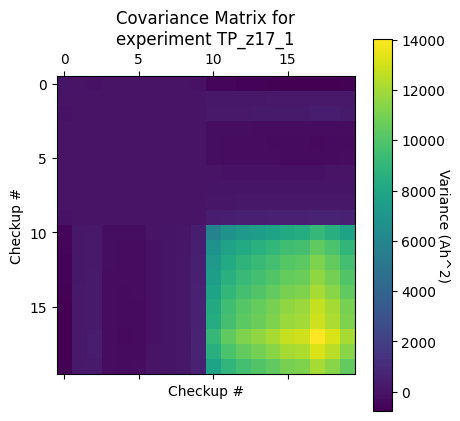

In [106]:
ind = np.argmax(max_covs)
fig = cov_plot(covs[ind], names[ind])

In [ ]:
ind = np.argmax(max_covs)
fig = cov_plot(covs[ind], names[ind])

In [103]:
def cov_plot(cov, name):
    # Minimum
    fig = plt.figure()
    plt.matshow(1e6 * cov)
    plt.title(f"Covariance Matrix for\nexperiment {name}")
    plt.xlabel("Checkup #")
    plt.ylabel("Checkup #")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Variance (Ah^2)', rotation=270)
    return fig

In [96]:
fig.savefig(image_dir / "bad_measurement.png")

In [ ]:
plt.figure()
plt.matshow(cov)
plt.colorbar()

In [ ]:
plt.figure()
plt.matshow(cov)
plt.colorbar()